# Traffic Danger warning sign

---

- OUEDRAOGO Taoufiq
- NGNINTEDEM Lionel
- NANFAH Manoel
- TONDJI Andrea

In [1]:
import kagglehub
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import img_to_array

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

import pickle
import cv2
from tqdm import tqdm
from pylab import text
from PIL import Image
#from skimage.transform import resize

c:\Users\nanfa\anaconda3\envs\personnal_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I. Download Data From Kaggle

In [2]:
# Download dataset used from Kaggle
dataset1 = "valentynsichkar/traffic-signs-dataset-in-yolo-format"
dataset2 = "valentynsichkar/traffic-signs-preprocessed"
#path = kagglehub.dataset_download(dataset1)

#print("Path to dataset files:", path)

In [4]:
# Number of Images
#len(os.listdir(path+'/ts/ts')) / 2

You are not obliged to run step 1. and 2. since the data has already been organized

## 1. Move data into our current folder

## 2. Split Files into "Danger" folder and "Others" folder

In [6]:
len_danger = len(os.listdir('./data/Classes/Danger'))
len_others = len(os.listdir('./data/Classes/Others'))
len_danger, len_others, len_danger + len_others

(165, 576, 741)

## 3. Visualization of Class

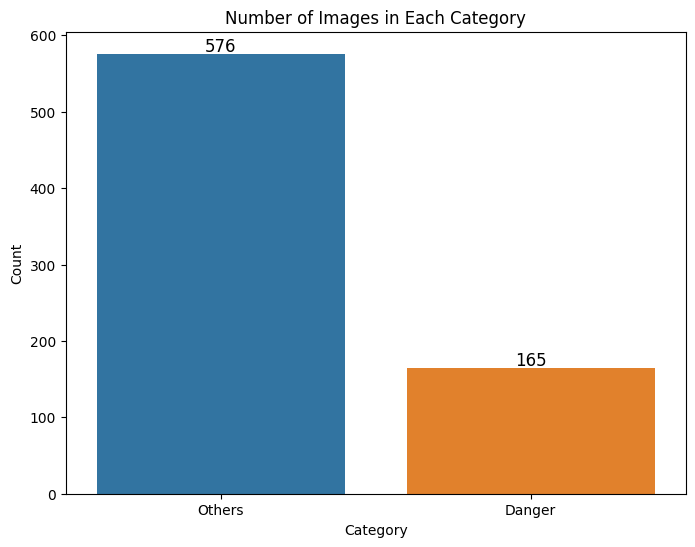

In [7]:
# Get the number of files in each directory
others_count = len(os.listdir('./data/Classes/Others'))
danger_count = len(os.listdir('./data/Classes/Danger'))

# Create a DataFrame for plotting
data = pd.DataFrame({'Category': ['Others', 'Danger'],
    'Count': [others_count, danger_count]})

# Plot the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Category', y='Count', data=data, hue='Category', legend=False)
plt.title('Number of Images in Each Category')
plt.xlabel('Category')
plt.ylabel('Count')

# Add the count value on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')
plt.show()

# II. Data Preparation

## 1. Data Generator

This code generates data generators for training, validation, and test sets using images and their corresponding labels stored in pandas DataFrames.

Each generator uses the flow_from_dataframe method from Keras’ ImageDataGenerator to load and preprocess the images, resizing them to a fixed size and batching them for efficient processing.

The training, validation, and test sets are handled separately using different DataFrames (train_images, val_images, and test_images), and each batch contains images and labels suitable for binary classification (0 or 1). 

These generators allow the model to train, validate, and test efficiently with preprocessed data.

In [3]:
# Configuration des chemins et des paramètres
data_dir = './data/Classes'  # Dossier contenant les sous-dossiers "Danger" et "Others"
img_height, img_width = 128, 128
batch_size = 32

# Générateur principal de données
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2,
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Shear images by up to 20%
    zoom_range=0.2,  # Zoom into the images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest',  # Filling missing pixels after transformations
)

# Charger les images et labels depuis les sous-dossiers
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True, 
    subset='training'
)

 
# Générer les sous-ensembles de validation  
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True, 
    subset='validation'
)

Found 593 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


# III. Modeling

This  initializes a convolutional neural network (CNN) for binary image classification. 

It starts by adding convolutional layers with ReLU activation and max-pooling layers to reduce the spatial dimensions of the feature maps. 

The network has three sets of convolutional layers, each followed by max-pooling. Afterward, the feature maps are flattened into a 1D vector using the Flatten layer. 

The model then adds two fully connected layers: one with 128 units and ReLU activation, and another with a single unit and a sigmoid activation function for binary classification. 

The model is compiled with the Adam optimizer, binary cross-entropy loss (appropriate for binary classification), and accuracy as a performance metric.

In [36]:
model1 = Sequential() # Initialization  

model1.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

model1.add(Flatten())  # Flattening 
model1.add(Dense(64, activation='relu'))    # Fully Connected Layer
model1.add(Dense(1, activation='sigmoid'))    # Sigmoid for binary classification 

# Compilation du modèle
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 28800)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [26]:
history1 = model1.fit(train_generator, epochs=10, verbose=True, validation_data=validation_generator)

Epoch 1/10
19/19 [==============================] - 8s 385ms/step - loss: 0.6371 - accuracy: 0.7504 - val_loss: 0.5316 - val_accuracy: 0.7770
Epoch 2/10
19/19 [==============================] - 7s 353ms/step - loss: 0.5492 - accuracy: 0.7774 - val_loss: 0.5203 - val_accuracy: 0.7770
Epoch 3/10
19/19 [==============================] - 7s 356ms/step - loss: 0.5409 - accuracy: 0.7774 - val_loss: 0.5232 - val_accuracy: 0.7770
Epoch 4/10
19/19 [==============================] - 7s 355ms/step - loss: 0.5395 - accuracy: 0.7774 - val_loss: 0.5133 - val_accuracy: 0.7770
Epoch 5/10
19/19 [==============================] - 7s 353ms/step - loss: 0.5350 - accuracy: 0.7774 - val_loss: 0.5215 - val_accuracy: 0.7770
Epoch 6/10
19/19 [==============================] - 7s 357ms/step - loss: 0.5323 - accuracy: 0.7774 - val_loss: 0.5381 - val_accuracy: 0.7770
Epoch 7/10
19/19 [==============================] - 7s 355ms/step - loss: 0.5358 - accuracy: 0.7774 - val_loss: 0.5343 - val_accuracy: 0.7770
Epoch 

## Plot Loss and Accuracy

The results indicate that the model struggles to learn effectively due to class imbalance in the dataset, with 576 samples in the "Other" class (77.7%) and only 165 in the "Danger" class (22.3%). 
- Training accuracy starts at 75.04% and quickly stabilizes at 77.74%, while validation accuracy remains constant at 77.70% across all epochs
- Similarly, training loss decreases slightly, but validation loss fluctuates without a clear improvement. 

These trends suggest that the model is underfitting and may be biased toward the majority class, leading to poor performance on the minority class.

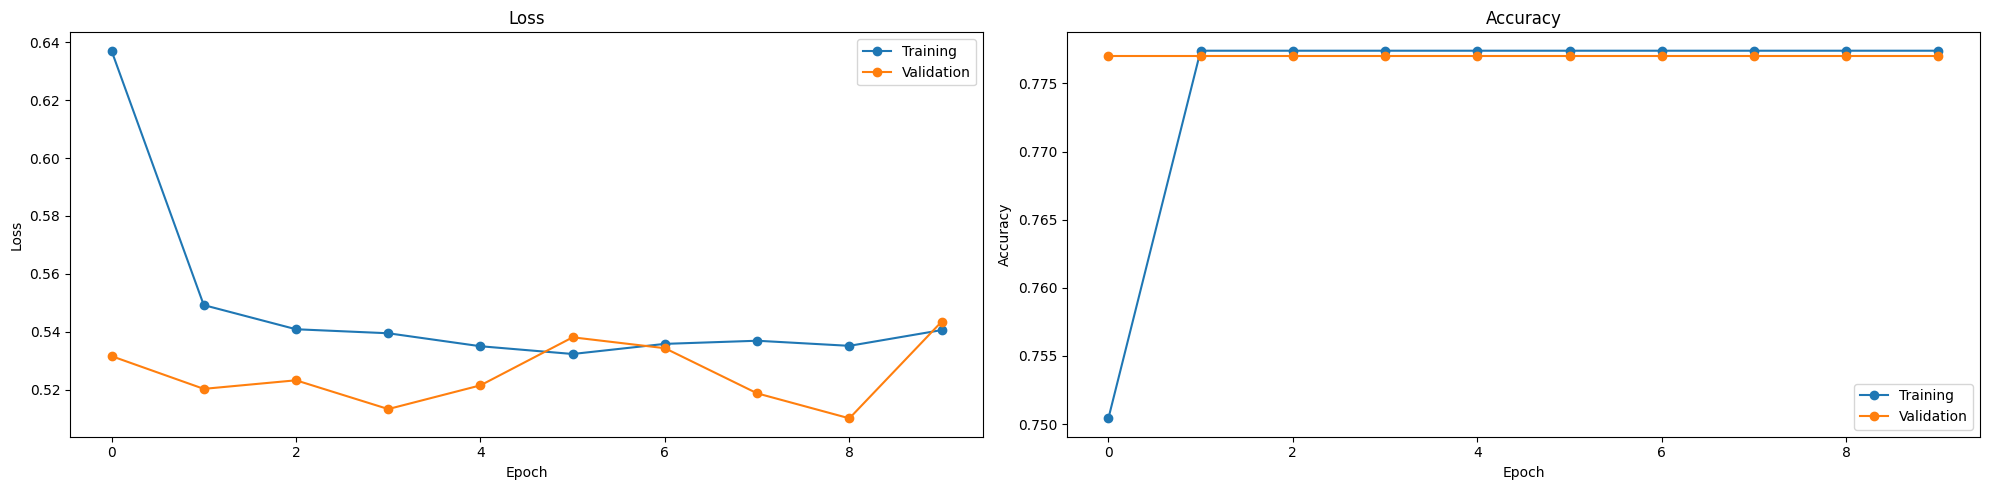

In [27]:
# Plot Loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training', marker='o')
plt.plot(history1.history['val_loss'], label='Validation', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Training', marker='o')
plt.plot(history1.history['val_accuracy'], label='Validation', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


## Used Class Weight 

Given the imbalanced classes in our dataset (“DANGER” with 165 instances and “OTHERS” with 576), the model might be biased toward predicting the majority class, “OTHERS.” This could explain why the model achieves high accuracy on training data but struggles on validation data, as it focuses on the majority class and neglects the minority class.
- The model tends to predict “OTHERS” more often, since it’s the majority class, leading to good accuracy but poor performance on “DANGER.”
- Accuracy Is Misleading: High accuracy doesn’t mean good performance for both classes. The model may perform well on “OTHERS” but fail on “DANGER.”

In [61]:
# Calculate class weights based on the labels
n_0 = pd.Series(train_generator.classes).value_counts()[0]
n_1 = pd.Series(train_generator.classes).value_counts()[1]
labels = [0] * n_0 + [1] * n_1  # Assuming 0 = 'Others', 1 = 'Danger'

# Compute class weights using sklearn utility
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

# Convert to dictionary format expected by Keras
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: 2.246212121212121, 1: 0.6431670281995662}

In [59]:
model1 = Sequential() # Initialization  
model1.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())  # Flattening 
model1.add(Dense(64, activation='relu'))    # Fully Connected Layer
model1.add(Dense(1, activation='sigmoid'))    # Sigmoid for binary classification 
# Compilation du modèle
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history2 = model1.fit(train_generator, epochs=10, class_weight=class_weight_dict, validation_data=validation_generator)

Epoch 1/10
19/19 [==============================] - 9s 453ms/step - loss: 0.8524 - accuracy: 0.5464 - val_loss: 0.7740 - val_accuracy: 0.2230
Epoch 2/10
19/19 [==============================] - 7s 395ms/step - loss: 0.6962 - accuracy: 0.2226 - val_loss: 0.7205 - val_accuracy: 0.2230
Epoch 3/10
19/19 [==============================] - 12s 628ms/step - loss: 0.6906 - accuracy: 0.3845 - val_loss: 0.7047 - val_accuracy: 0.3919
Epoch 4/10
19/19 [==============================] - 12s 644ms/step - loss: 0.6875 - accuracy: 0.4536 - val_loss: 0.7060 - val_accuracy: 0.4595
Epoch 5/10
19/19 [==============================] - 13s 669ms/step - loss: 0.7004 - accuracy: 0.4772 - val_loss: 0.6829 - val_accuracy: 0.6014
Epoch 6/10
19/19 [==============================] - 12s 611ms/step - loss: 0.6908 - accuracy: 0.6239 - val_loss: 0.7030 - val_accuracy: 0.3176
Epoch 7/10
19/19 [==============================] - 10s 552ms/step - loss: 0.6873 - accuracy: 0.4536 - val_loss: 0.6825 - val_accuracy: 0.5676
E

The fluctuations and inconsistent improvements in both training and validation accuracy point to a lack of stable learning, potentially caused by class imbalance, despite applying class weights. 
- The model likely struggles to focus on the minority class "Danger," as the dataset is heavily skewed toward the "Other" class

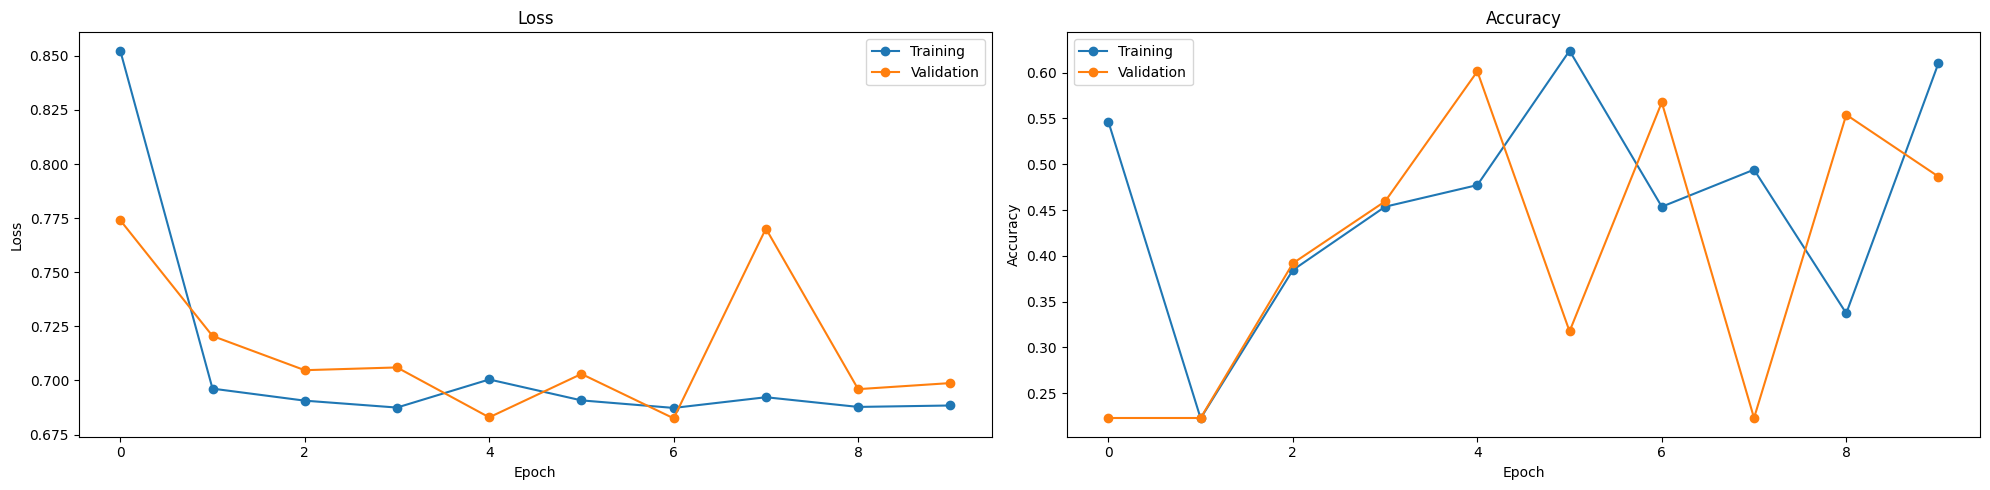

In [60]:
# Plot Loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training', marker='o')
plt.plot(history2.history['val_loss'], label='Validation', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Training', marker='o')
plt.plot(history2.history['val_accuracy'], label='Validation', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# IV. Test with Added Images from Video

___


[Click here to watch the youtube video](https://youtu.be/A3pw_ktIcdM)

For the study, wet the start time to 10 seconds and end time to 1 minute 58 seconds


## 1. Transform Video into Images

This code extracts frames from a video and rename each frame with its frame number. 
- Using OpenCV, the video is read frame by frame, and each frame is saved as an image in a specified folder.
- The frame is optionally labeled with text (like the frame number)
- This process is important for creating datasets used in machine learning tasks, such as object detection, where labeled frames are needed for training models


## 2. Labelization

**Danger category** consists of following Traffic Sings: priority at next intersection, danger, bend left, bend right, bend, uneven road, slippery road, road narrows, construction, traffic signal, pedestrian crossing, school crossing, cycles crossing, snow, animals.


The code below extracts frames from the video, displaying each frame in a window. We can click on a frame to save it as an image in a specified folder if the frame contains the object class considered in our project (here, a danger sign). 

We don't use this code since we have already added the data in the folder './data/Classes_with_video_content/Danger'

## Adding images from video to the training

Images from the video are labelled as follow: "video_test_frame_xxxx.jpg"

In [2]:
len_danger = len(os.listdir('./data/Classes_with_video_content/Danger'))
len_others = len(os.listdir('./data/Classes_with_video_content/Others'))
len_danger, len_others, len_danger + len_others

(1733, 576, 2309)

In [3]:
data_dir2 = './data/Classes_with_video_content/'
# Configuration des chemins et des paramètres
img_height, img_width = 128, 128
batch_size = 32

# Générateur principal de données
datagen2 = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.8,  # Use 80% for training, 20% for validation
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Shear images by up to 20%
    zoom_range=0.2,  # Zoom into the images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest',  # Filling missing pixels after transformations
)

# Charger les images et labels depuis les sous-dossiers
train_generator2 = datagen2.flow_from_directory(
    data_dir2,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True, 
    subset='training'
)

 
# Générer les sous-ensembles de validation  
validation_generator2 = datagen2.flow_from_directory(
    data_dir2,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True, 
    subset='validation'
)

Found 463 images belonging to 2 classes.


Found 1846 images belonging to 2 classes.


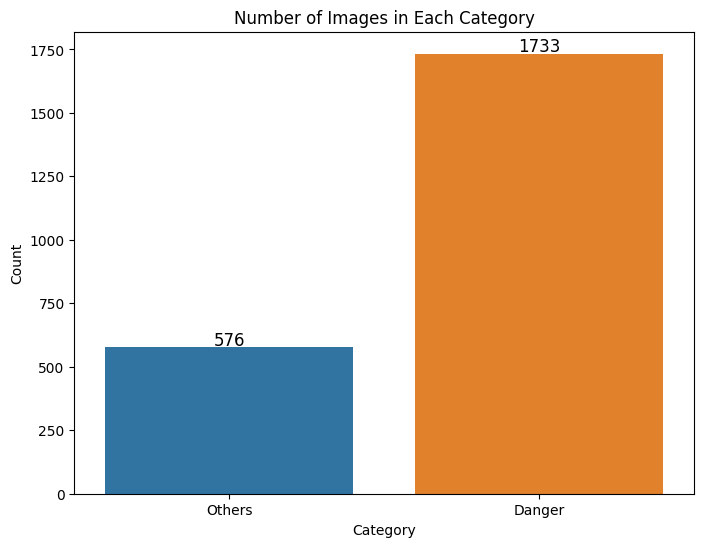

In [64]:
# Get the number of files in each directory
others_count = len(os.listdir('./data/Classes_with_video_content/Others'))
danger_count = len(os.listdir('./data/Classes_with_video_content/Danger'))

# Create a DataFrame for plotting
data = pd.DataFrame({'Category': ['Others', 'Danger'],
    'Count': [others_count, danger_count]})

# Plot the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Category', y='Count', data=data, hue='Category', legend=False)
plt.title('Number of Images in Each Category')
plt.xlabel('Category')
plt.ylabel('Count')

# Add the count value on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')
plt.show()

In [ ]:
model2 = Sequential() # Initialization

model2.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Flatten())  # Flattening 
model2.add(Dense(64, activation='relu'))    # Fully Connected Layer
model2.add(Dense(1, activation='sigmoid'))    # Sigmoid for binary classification 

# Compilation du modèle
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history3 = model2.fit(train_generator2, epochs=10, verbose=True, validation_data=validation_generator2)

The results demonstrate strong training performance, with accuracy steadily improving to 98.49% by the final epoch and consistently low training loss. 

However, validation accuracy fluctuates between 78.33% and 87.00%, indicating variability in the model's ability to generalize. Early on, validation accuracy is promising, peaking at 86.24% in the final epoch.

The initial performance indicates the model quickly learns to distinguish classes, likely due to balanced data. However, as training progresses, the model seems to overfit, excelling on training data but struggling with validation.

To improve, regularization techniques like dropout, weight decay, or early stopping could be applied to reduce overfitting. Additionally, fine-tuning the learning rate or augmenting validation data might help the model generalize better, resulting in more stable validation metrics.

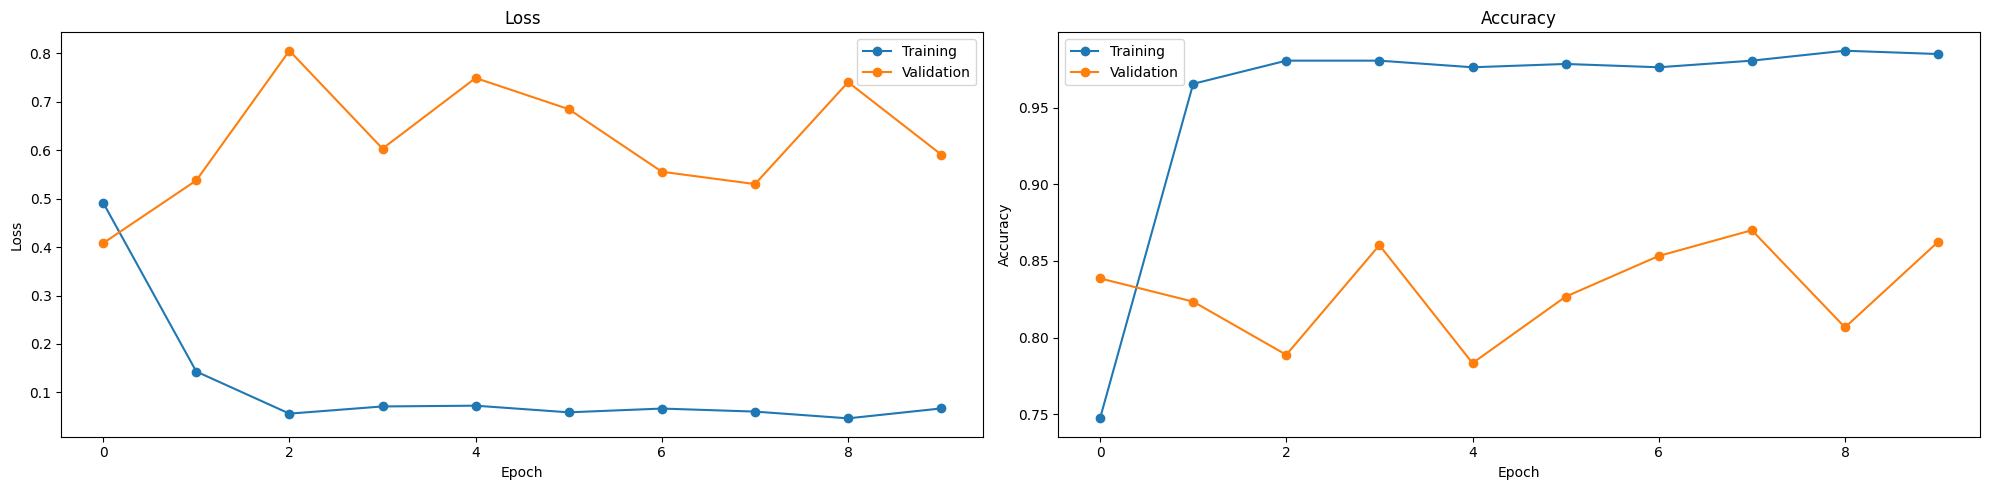

In [66]:
# Plot Loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training', marker='o')
plt.plot(history3.history['val_loss'], label='Validation', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='Training', marker='o')
plt.plot(history3.history['val_accuracy'], label='Validation', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Use class weight


In [67]:
# Calculate class weights based on the labels
n_0 = pd.Series(train_generator2.classes).value_counts()[0]
n_1 = pd.Series(train_generator2.classes).value_counts()[1]
labels = [0] * n_0 + [1] * n_1  # Assuming 0 = 'Others', 1 = 'Danger'

# Compute class weights using sklearn utility
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

# Convert to dictionary format expected by Keras
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: 0.6671469740634006, 1: 1.9956896551724137}

In [ ]:
model2 = Sequential() # Initialization

model2.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Flatten())  # Flattening 
model2.add(Dense(64, activation='relu'))    # Fully Connected Layer
model2.add(Dense(1, activation='sigmoid'))    # Sigmoid for binary classification 

# Compilation du modèle
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history4 = model2.fit(train_generator2, epochs=10, verbose=True, validation_data=validation_generator2)

Epoch 1/3
15/15 [==============================] - 34s 2s/step - loss: 0.6427 - accuracy: 0.7084 - val_loss: 0.5488 - val_accuracy: 0.7508
Epoch 2/3
15/15 [==============================] - 28s 2s/step - loss: 0.4049 - accuracy: 0.7495 - val_loss: 0.4507 - val_accuracy: 0.7508
Epoch 3/3
15/15 [==============================] - 27s 2s/step - loss: 0.2699 - accuracy: 0.8898 - val_loss: 0.3603 - val_accuracy: 0.8348


In [ ]:
history4

The results show that the model performs well on training data, with accuracy rising to 99.35% by the end of training. However, validation accuracy fluctuates significantly throughout the epochs, starting low at 56.83% in the first epoch and reaching a peak of 88.19% in the last epoch. This suggests that while the model is learning effectively from the training data, it struggles with generalization to the validation set.

The validation loss is also inconsistent, with values ranging from 0.6924 in Epoch 1 to 0.7056 in Epoch 10. This variability in validation metrics indicates some level of overfitting, where the model performs well on the training data but faces difficulty in maintaining similar performance on unseen validation data.

To address this, the model could benefit from additional regularization techniques such as dropout, early stopping, or using a more balanced dataset. This would help improve generalization and stabilize validation performance.

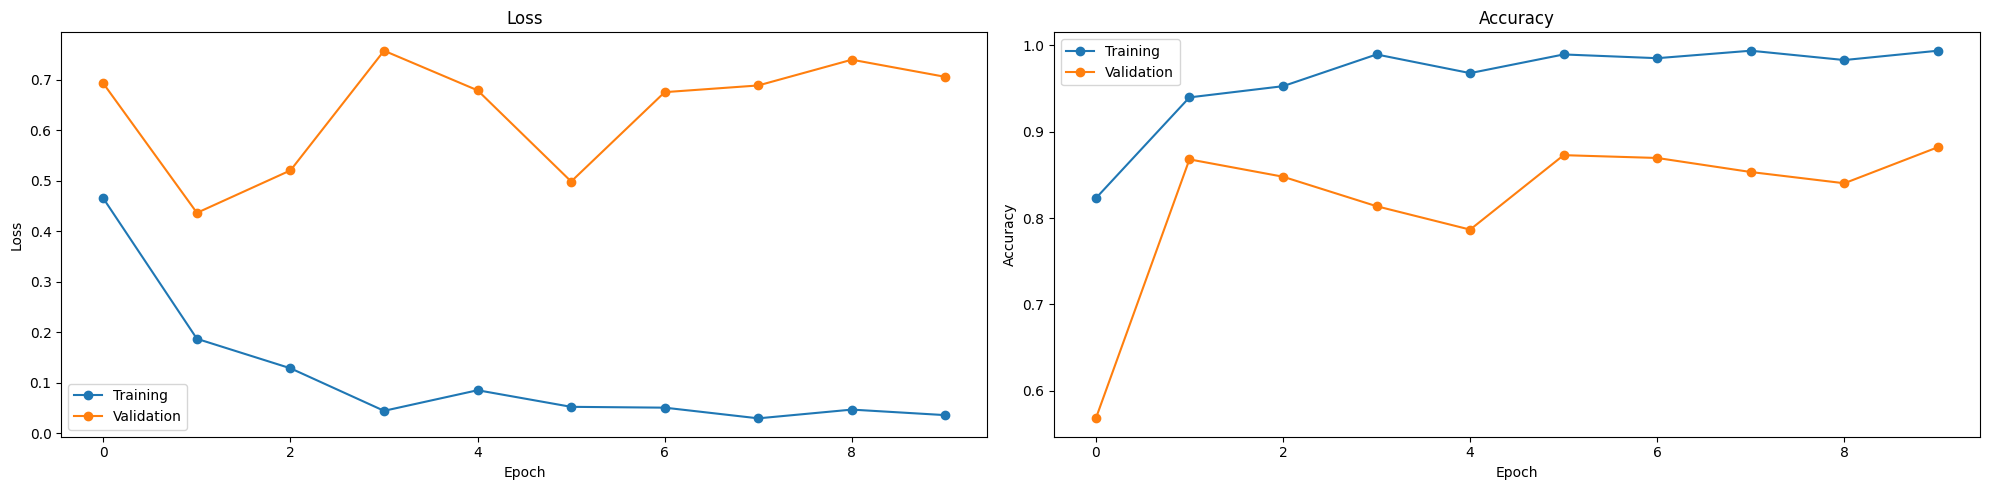

In [69]:
# Plot Loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='Training', marker='o')
plt.plot(history4.history['val_loss'], label='Validation', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'], label='Training', marker='o')
plt.plot(history4.history['val_accuracy'], label='Validation', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Test the model on a video

There are a multitude of danger signs (about 30).

For better modeling:
- We should make sure that our training data contains a significant number of images for each of the types of danger signs 

https://fr.wikipedia.org/wiki/Liste_des_signaux_routiers_de_danger_en_France


The data used did not differentiate between these categories of panels but for more precision it should have been done

In [6]:
cap = cv2.VideoCapture('video_test.mp4')

if not cap.isOpened():
    print("Error: Could not open video.")

In [ ]:
while True:
    ret, frame = cap.read()
    
    # Break the loop if no more frames are available
    if not ret:
        break

    # Preprocess the frame
    resized_frame = cv2.resize(frame, (128, 128))
    input_frame = img_to_array(resized_frame) / 255.0  # Normalize pixel values to [0, 1]
    input_frame = np.expand_dims(input_frame, axis=0)  # Add batch dimension

    # Make predictions
    prediction = model2.predict(input_frame)
    label = "Object Detected" if prediction >= 0.5 else "No Object"

    # Display the frame and prediction
    print(label)
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Video', frame)

    # Press 'q' to exit the video display window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
#cap.release()
#cv2.destroyAllWindows()

1/1 [==============================] - 0s 56ms/step
Object Detected
1/1 [==============================] - 0s 67ms/step
Object Detected
1/1 [==============================] - 0s 59ms/step
Object Detected
1/1 [==============================] - 0s 69ms/step
Object Detected
1/1 [==============================] - 0s 63ms/step
Object Detected
1/1 [==============================] - 0s 69ms/step
Object Detected
1/1 [==============================] - 0s 62ms/step
Object Detected
1/1 [==============================] - 0s 66ms/step
Object Detected
1/1 [==============================] - 0s 65ms/step
Object Detected
1/1 [==============================] - 0s 64ms/step
Object Detected
1/1 [==============================] - 0s 110ms/step
Object Detected
1/1 [==============================] - 0s 53ms/step
Object Detected
1/1 [==============================] - 0s 52ms/step
Object Detected
1/1 [==============================] - 0s 36ms/step
Object Detected
1/1 [==============================] - 0s 52ms/

: 